In [1]:
import torch
import pyro

from typing import Dict, List
from scipy.stats import entropy
from scipy.stats import beta
import pyro.distributions as dist

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns



A video shows a men part of ISIS beheading another person. The question is identity. The man in the video has a pair of missing fingers. A suspect is identified, has missing fingers and matches other characteristics (travelled to Syria, participated in ISIS etc.). Suspect denies beheading the person in the video.

Key identification evidence:

    suspect's missing fingers are missing in the same places as the missing fingers of the person in the video.
    probability of random match in Swedish population based on police database is assessed to be 2/20,000
    only 2 matches in 20,000 entry database
    matching fingers of people in database are of people who died at the time of the crime

Missing evidence:

    database is based on Swedish population, not ISIS members, random match probability could have been different

Suspect is acquitted or charges because evidence was not robust

Interesting quotation:
"The court explains that a random match probability of 1 in 10 000 would have been sufficient for proof beyond
reasonable doubt, given the other circumstances of the case, if this probability had
been robust, but in the absence of more reference data on people affiliated with ISIS it
is not sufficiently robust for the standard of proof in criminal cases." (p. 142)

Weight question in this case:

    Had an ISIS database been available at trial, how would the overall evidence have changed?


In [2]:
# this is just a definition of a function that we will be using for sampling from the model and 
# creating plots of the samples

def plot_from_nodes(nodes, filters: Dict[str, float] = None, nodes_to_plot: List[str] = None, bins = 20):

    """
   The plot_from_nodes function takes a dictionary of nodes, processes their values, optionally filters the data,
    and plots histograms for specified nodes. The function then returns the processed DataFrame.
    Parameters:
    - nodes: Dictionary of nodes containing data.
    - filters: Optional dictionary to filter the data based on specified conditions.
    - nodes_to_plot: Optional list of specific nodes to plot. If not provided, plots all nodes.
    - bins: Number of bins for the histograms (default is 20).

    Returns:
    - DataFrame of the processed values.
    """

    values = {key: nodes[key]['value'].float().detach().cpu().numpy() for key in nodes.keys() if nodes[key]['name'] != 'samples'}

    valuesDF = pd.DataFrame(values)

    if filters is not None:
        for key in filters.keys():
            valuesDF = valuesDF[valuesDF[key] == filters[key]]

    if nodes_to_plot is None:
        nodes_to_plot = values.keys()

    for key in nodes_to_plot:
        plt.figure()
        plt.hist(valuesDF[key], bins=bins, alpha=0.7, color='blue', density=True)
        plt.title(f"{key}, mean: {valuesDF[key].mean()}")
        plt.xlabel('value')
        plt.ylabel('frequency')
        sns.despine()
        plt.show()  

    return valuesDF

The function below calculates weight of evidence of a posterior $p$ in a following manner, where $H = -\sum p \log(p)$:$$ W(p) = 1 - \frac{H(p)}{H(\text{uniform})} $$

In [3]:
def weight(posterior: List[float], base = 2) -> float:

    grid_length = len(posterior)
    x = np.linspace(0, 1, grid_length)
    uniform = beta.pdf(x, 1, 1) # def. of a uniform distribution given the size of the posterior
    
    entropy_uniform = entropy(uniform, base=base) # entropy H(uniform)
    entropy_posterior = entropy(posterior, base=base) # entropy H(p)
    return 1 - entropy_posterior/entropy_uniform # weight = 1 - H(p)/H(uniform)


In [4]:
# this short chunk is just a demonstration of how the sampling process works,
# prob_guilty is an object (a tensor of scalars) sampled from Beta distribution with parameters 1, 1
# you can run this chunk multiple times to see how the value changes

prob_guilty = pyro.sample("prob_guilty", dist.Beta(1, 1e7))
prob_guilty

tensor(6.4502e-08)

This model will show us the probability of being guilty for a person with missing fingers (when fingers = 1) when we use the Swedish dataset to assess the probability of missing fingers.

In [5]:
def fingers_model_just_sweden():
    """
    fingers_model_just_sweden is a model defined as a function in Pyro. 
    Each line defines a variable used in the probabilistic model. The function is run n amount of times, to sample from the model, as
    the objects itroduced here are tensors of floats.
    """
    
    # Sample the probability of being the person responsible (a single value) from a Beta distribution
    prob_identity = pyro.sample("prob_identity", dist.Beta(2, 301))  # suppose 1 of 300 fighters in Sweden is responsible 

    # Sample the binary outcome of being identical (0 or 1) from a Bernoulli distribution with the probability: prob_identity
    identity = pyro.sample("identity", dist.Bernoulli(prob_identity))

    
    # Sample the probability of having fingers misssing if Swedish from a Beta distribution with parameters 3 and 20001
    pr_match_if_swedish = pyro.sample("pr_match_if_swedish", dist.Beta(3, 20001)) # 2 fingers in 20,000 Swedes
    
    # Define the deterministic probability of having fingers missing, which is 1 if identity and pr_match_if_swedish if not identity
    prob_match = pyro.deterministic("prob_match", identity * 1 + (1 - identity) * pr_match_if_swedish)
    
    # when identity is 0, then the probability of having fingers missing is equall to pr_match_if_swedish,
    # when identity is 1, then the probability of having fingers missing is 1
    
    # Sample the binary outcome of having fingers missing from a Bernoulli distribution with the probability pr_fingers
    match = pyro.sample("match", dist.Bernoulli(prob_match))



# Render the model to visualize its structure
pyro.render_model(fingers_model_just_sweden)

# Trace the execution of the model with 100,000 data points
with pyro.poutine.trace() as tr:
    with pyro.plate("data", 1e7):
        fingers_model_just_sweden()


/home/rafal/.local/lib/python3.10/site-packages/torch/cuda/__init__.py:628: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


KeyboardInterrupt: 

odict_keys(['data', 'prob_identity', 'identity', 'pr_match_if_swedish', 'prob_match', 'match'])


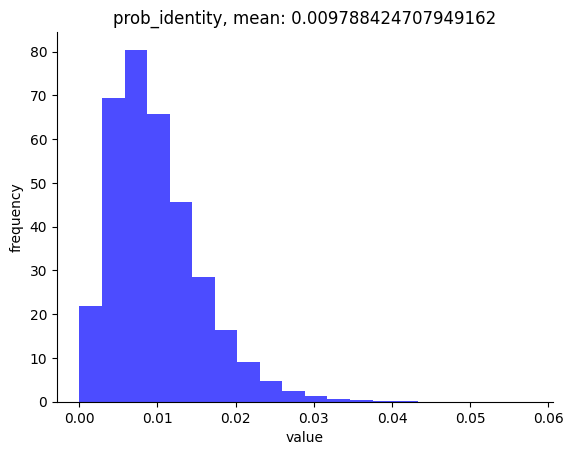

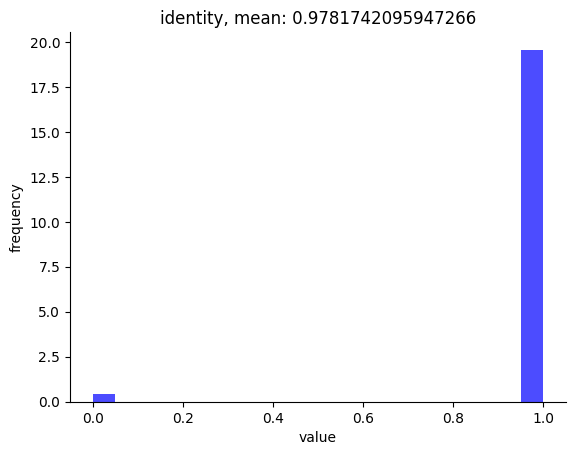

In [ ]:

# Extract the nodes from the trace
nodes = tr.trace.nodes

print(nodes.keys())
# Plot the specified nodes, filtering for cases where fingers == 1.0, for that records we look at the probability of missing fingers if Swedish
# and the probability of being identity
table = plot_from_nodes(nodes, filters={'match': 1.0}, nodes_to_plot=["prob_identity", "identity"])

# This function also returns a DataFrame of the processed values


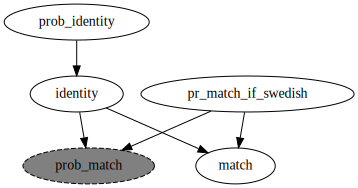

In [ ]:
pyro.render_model(fingers_model_just_sweden)

# this is a graph that ought to show the relation between the defined variables
# (not sure why fingers_prob looks like that)

This model will show us the probability of being guilty for a person with missing fingers (when fingers = 1) when the probability of missing fingers is represented as a uniform distribution between `pr_fingers_if_swedish` and `n * pr_fingers_if_swedish` resembling higher probability of missing fingers among ISIS members.

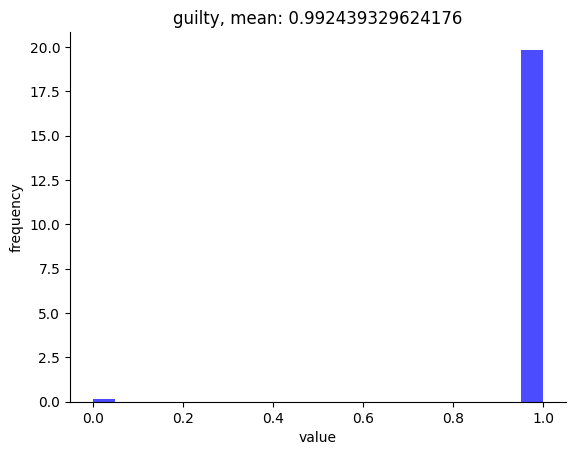

Weight of evidence for guilt: 0.9358515111043194


In [ ]:
def fingers_model():

    prob_guilty = pyro.sample("prob_guilty", dist.Beta(1,1))  # this is unrealistically and extremely charitable if set to 1,1
    # as it means we have no prior belief about isis fighters torturing and killing people, while it was part of their modus operandi
    
    # guilty is a binary variable, 1 if guilty, 0 if not guilty, sampled from a Bernoulli distribution with the probability prob_guilty
    guilty = pyro.sample("guilty", dist.Bernoulli(prob_guilty))

    
    pr_fingers_if_swedish = pyro.sample("pr_fingers_if_swedish", dist.Beta(3, 20001))


    pr_fingers_if_isis = pyro.sample("pr_fingers_if_isis", dist.Uniform(pr_fingers_if_swedish, (100 * pr_fingers_if_swedish).clamp(0, 1)))  # charitably, chance of fingers if in isis 
    # it's assumed that the probability of having fingers missing if in ISIS is 100 times higher than if Swedish
    # pr_fingers_if_isis samples from uniform dist closed under pr_fingers_if_swedish and 100 * pr_fingers_if_swedish
    # clamp just ensures that the value is between 0 and 1 
     
     
     
    #pr_fingers_if_isis =  0.01  
                                                                              
                                                                                                                                  
    pr_fingers = pyro.deterministic("fingers_prob", guilty * 1 + 
                                        (1 - guilty) * pr_fingers_if_isis)
    # when guilty is 0, then the probability of having fingers missing is equall to pr_fingers_if_isis,
    # when guilty is 1, then the probability of having fingers missing is 1
    
    fingers = pyro.sample("fingers", dist.Bernoulli(pr_fingers))


 
pyro.render_model(fingers_model)

with pyro.poutine.trace() as tr:
    with pyro.plate("data", 100000):
        fingers_model()

nodes = tr.trace.nodes


df = plot_from_nodes(nodes, filters = {'fingers': 1.0}, nodes_to_plot=["guilty"])# plotting guilt distribution, when fingers are missing
# saving the data frame as df, to use it later


posterior_guilt =  [df['guilty'].mean(), 1 - df['guilty'].mean()]
# taking the mean of the guilty column, to get the probability of guilt, and then the probability of innocence, 
# df['guilty'] is just a column containing the sample

# posterior_guilt contains 2 values calculated above, the probability of guilt and the probability of innocence
print(f"Weight of evidence for guilt: {weight(posterior_guilt)}")# calculating the weight of evidence for guilt,
# visible at the bottom of the graph


In [ ]:
# just a quick look how this variable looks like
posterior_guilt

[0.9924393, 0.007560670375823975]

This model will show us the probability of being guilty for a person with missing fingers (when fingers = 1) when the probability of missing fingers for isis members is represented as a **Beta** distribution, with parameters $(8, 1001)$, to exemplify 7 people with missing fingers in a group of 1000 ISIS members.

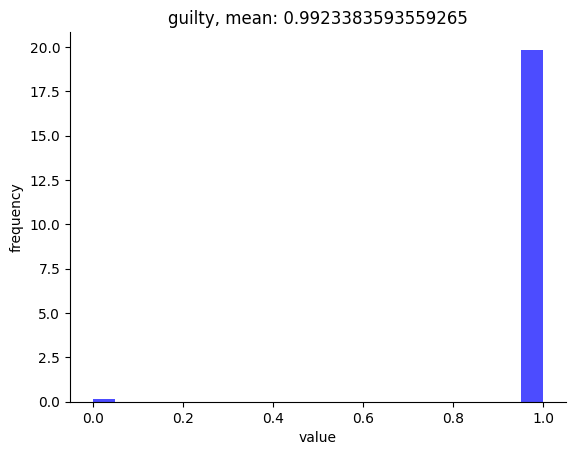

Weight of evidence for guilt: 0.9351420276834422


In [ ]:
def fingers_model():

    prob_guilty = pyro.sample("prob_guilty", dist.Beta(1, 1))  # this is unrealistically and extremely charitable if set to 1,1
    # as it means we have no prior belief about isis fighters torturing and killing people, while it was part of their modus operandi

    guilty = pyro.sample("guilty", dist.Bernoulli(prob_guilty))

    # the only difference is that the probability of having fingers missing if in ISIS is now sampled from a Beta distribution
    pr_fingers_if_isis = pyro.sample("pr_fingers_if_isis",  dist.Beta(8, 1001))  # charitably, chance of fingers if in isis


    pr_fingers = pyro.deterministic("fingers_prob", guilty * 1 + 
                                        (1 - guilty) * pr_fingers_if_isis)
    
    fingers = pyro.sample("fingers", dist.Bernoulli(pr_fingers))

pyro.render_model(fingers_model)

with pyro.poutine.trace() as tr:
    with pyro.plate("data", 100000):
        fingers_model()

nodes = tr.trace.nodes
df = plot_from_nodes(nodes, filters = {'fingers': 1.0}, nodes_to_plot=["guilty"])

posterior_guilt =  [df['guilty'].mean(), 1 - df['guilty'].mean()]
print(f"Weight of evidence for guilt: {weight(posterior_guilt)}")

In [ ]:
def fingers_pointwise_with_isis(prob_identity, pr_random_match):
    
    identity = pyro.sample("identity", dist.Bernoulli(prob_identity))
    
    pr_match = pyro.deterministic("fingers_prob", identity * 1 + 
                                        (1 - identity) * pr_random_match)
    
    # Sample the binary outcome of having fingers missing from a Bernoulli distribution with the probability pr_fingers
    match = pyro.sample("match", dist.Bernoulli(pr_match))

    return match



In [ ]:
def estimate_identity_posterior(prob_identity, pr_random_match, n_samples = 1e3):
    
    with pyro.poutine.trace() as estimation_tr:
        with pyro.plate("interior_estimation", n_samples):
            fingers_pointwise_with_isis(prob_identity, pr_random_match)

    mask = (estimation_tr.trace.nodes['match']['value'] == 1.0)
    posterior_sample = estimation_tr.trace.nodes['identity']['value'][mask].float().detach().cpu().numpy()
    posterior_estimate = posterior_sample.mean()
    
    return posterior_estimate

estimate_identity_posterior(0.2,.2)


0.5592901

In [ ]:
def fingers_with_isis_and_uncertainty():

    with pyro.plate("outer_estimation", size = 100):
        prob_identity = pyro.sample("prob_identity", dist.Beta(2,301))  
        
        identity = pyro.sample("identity_outside", dist.Bernoulli(prob_identity))
        
        pr_random_match_if_swedish = pyro.sample("pr_random_match_if_swedish", dist.Beta(3, 20001))
        
        pr_random_match_if_isis = pyro.sample("pr_random_match_if_isis", dist.Uniform(pr_random_match_if_swedish, (100 * pr_random_match_if_swedish).clamp(0, 1)))  # charitably, chance of fingers if in isis 

        pr_match = pyro.deterministic("pr_match",  identity * 1 + 
                                            (1 - identity) * pr_random_match_if_isis, event_dim=0)
        
        posterior_estimate = torch.tensor(estimate_identity_posterior(prob_identity, pr_random_match_if_isis))

    #_pe = pyro.deterministic("posterior_estimate", posterior_estimate, event_dim=0)
    return posterior_estimate


posterior_estimate = fingers_with_isis_and_uncertainty()
     

#posterior_sample = tr.trace.nodes['posterior_estimate']['value'].float().detach().cpu().numpy()


posterior_estimate

In [ ]:
def fingers_model_just_sweden():
    """
    fingers_model_just_sweden is a model defined as a function in Pyro. 
    Each line defines a variable used in the probabilistic model. The function is run n amount of times, to sample from the model, as
    the objects itroduced here are tensors of floats.
    """
    
    # Sample the probability of being the person responsible (a single value) from a Beta distribution
    prob_identity = pyro.sample("prob_identity", dist.Beta(2, 301))  # suppose 1 of 300 fighters in Sweden is responsible 

    # Sample the binary outcome of being identical (0 or 1) from a Bernoulli distribution with the probability: prob_identity
    identity = pyro.sample("identity", dist.Bernoulli(prob_identity))

    
    # Sample the probability of having fingers misssing if Swedish from a Beta distribution with parameters 3 and 20001
    pr_match_if_swedish = pyro.sample("pr_match_if_swedish", dist.Beta(3, 20001)) # 2 fingers in 20,000 Swedes
    
    # Define the deterministic probability of having fingers missing, which is 1 if identity and pr_match_if_swedish if not identity
    prob_match = pyro.deterministic("prob_match", identity * 1 + (1 - identity) * pr_match_if_swedish)
    
    # when identity is 0, then the probability of having fingers missing is equall to pr_match_if_swedish,
    # when identity is 1, then the probability of having fingers missing is 1
    
    # Sample the binary outcome of having fingers missing from a Bernoulli distribution with the probability pr_fingers
    match = pyro.sample("match", dist.Bernoulli(prob_match))



# Render the model to visualize its structure
pyro.render_model(fingers_model_just_sweden)

# Trace the execution of the model with 100,000 data points
with pyro.poutine.trace() as tr:
    with pyro.plate("data", 1e7):
        fingers_model_just_sweden()


In [ ]:
def fingers_model():

    prob_guilty = pyro.sample("prob_guilty", dist.Beta(1,1))  # this is unrealistically and extremely charitable if set to 1,1
    # as it means we have no prior belief about isis fighters torturing and killing people, while it was part of their modus operandi
    
    # guilty is a binary variable, 1 if guilty, 0 if not guilty, sampled from a Bernoulli distribution with the probability prob_guilty
    guilty = pyro.sample("guilty", dist.Bernoulli(prob_guilty))

    
    pr_fingers_if_swedish = pyro.sample("pr_fingers_if_swedish", dist.Beta(3, 20001))


    pr_fingers_if_isis = pyro.sample("pr_fingers_if_isis", dist.Uniform(pr_fingers_if_swedish, (100 * pr_fingers_if_swedish).clamp(0, 1)))  # charitably, chance of fingers if in isis 
    # it's assumed that the probability of having fingers missing if in ISIS is 100 times higher than if Swedish
    # pr_fingers_if_isis samples from uniform dist closed under pr_fingers_if_swedish and 100 * pr_fingers_if_swedish
    # clamp just ensures that the value is between 0 and 1 
     
     
     
    #pr_fingers_if_isis =  0.01  
                                                                              
                                                                                                                                  
    pr_fingers = pyro.deterministic("fingers_prob", guilty * 1 + 
                                        (1 - guilty) * pr_fingers_if_isis)
    # when guilty is 0, then the probability of having fingers missing is equall to pr_fingers_if_isis,
    # when guilty is 1, then the probability of having fingers missing is 1
    
    fingers = pyro.sample("fingers", dist.Bernoulli(pr_fingers))


 
pyro.render_model(fingers_model)

with pyro.poutine.trace() as tr:
    with pyro.plate("data", 100000):
        fingers_model()

nodes = tr.trace.nodes


df = plot_from_nodes(nodes, filters = {'fingers': 1.0}, nodes_to_plot=["guilty"])# plotting guilt distribution, when fingers are missing
# saving the data frame as df, to use it later


posterior_guilt =  [df['guilty'].mean(), 1 - df['guilty'].mean()]
# taking the mean of the guilty column, to get the probability of guilt, and then the probability of innocence, 
# df['guilty'] is just a column containing the sample

# posterior_guilt contains 2 values calculated above, the probability of guilt and the probability of innocence
print(f"Weight of evidence for guilt: {weight(posterior_guilt)}")# calculating the weight of evidence for guilt,
# visible at the bottom of the graph
